In [1]:
# -*- coding: utf-8 -*-
##############
#  Packages  #
##############
import os
import sys 


from pathlib import Path
import seaborn as sns 
import plotly.express as px
from plotly.offline import plot
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from umap import UMAP

from tqdm import tqdm


pio.renderers = "browser"

##################
#      Imports   #
##################
root_path = Path("C:/Users/Charles/Desktop/MVA/GDA/Geom_stat/")
sys.path.insert(0, str(root_path))

from utils_tda_and_clustering import (
    homology_parquet_to_matrix_bootstraps,
    make_pca_bootstraps,
    get_clusters
)

img_path = root_path.joinpath("raw_images")
saving_path = root_path.joinpath("outputs")

In [2]:
base_name = "b1"
base_path = str(saving_path.joinpath(f"{base_name}.parquet"))
df_ident, bootstraps, original = homology_parquet_to_matrix_bootstraps(base_path)

100%|██████████| 100/100 [07:36<00:00,  4.56s/it]


In [3]:
reduced_bootstraps, reduced_original, vars_explained = make_pca_bootstraps(bootstraps, original)

In [4]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from gap_statistic import OptimalK

def optimalK(reduced_bootstraps,  reduced_original, minClusters=2, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(minClusters, maxClusters)),))
    resultsdf = {}
    for gap_index, k in enumerate(range(minClusters, maxClusters)):# Holder for reference dispersion results
        refDisps = np.zeros(len(bootstraps))# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i,b in tqdm(enumerate(reduced_bootstraps)):

            clustering_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
            clustering_model.fit(b["reduced"])
            clusters_indices = clustering_model.labels_

            clusters = [[b["reduced"][j] for j in range(len(clusters_indices)) if clusters_indices[j]==i] for i in range(k)]
            
            distances = []
            for c in clusters:
                D_c = np.sum(pdist(c, 'euclidean'))/(2*len(c))
                distances.append(D_c)
            
            bootstrapDisp = np.sum(distances) # The value of W_k for one of our bootstraps
            refDisps[i] = bootstrapDisp
        
        clustering_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
        clustering_model.fit(reduced_original["reduced"])
        clusters_indices = clustering_model.labels_
        
        clusters = [[reduced_original["reduced"][j] for j in range(len(clusters_indices)) if clusters_indices[j]==i] for i in range(k)]
        
        distances = []
        for c in clusters:
            D_c = np.sum(pdist(c, 'euclidean'))/(2*len(c))
            distances.append(D_c)
        
        origDisp = np.sum(distances)
        
        gap = np.mean(np.log(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf[k] = gap
    return (gaps.argmax() + minClusters, resultsdf)

In [5]:
optimalK(reduced_bootstraps, reduced_original)

100it [00:18,  5.43it/s]
100it [00:17,  5.69it/s]
100it [00:16,  6.10it/s]
100it [00:17,  5.85it/s]
100it [00:18,  5.46it/s]
100it [00:16,  6.12it/s]
100it [00:16,  6.12it/s]
100it [00:16,  6.05it/s]


(2,
 {2: 0.023344783514916756,
  3: -0.001748319813382082,
  4: -0.003574050466468748,
  5: 0.0011163023095832614,
  6: 0.0035644774295580106,
  7: 0.0037812403400820926,
  8: -0.001195158541353436,
  9: -0.005138273232700996})

In [6]:
clustered_bootstraps, clustered_original = get_clusters(reduced_bootstraps, reduced_original)

In [7]:
from utils_tda_and_clustering import transform_gleason

In [8]:
gleason_bootstraps = transform_gleason(bootstraps)

In [9]:
gleason_points = np.array([b["gleason_coords"] for b in gleason_bootstraps]).reshape(-1,3)

In [48]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from gap_statistic import OptimalK

def optimalK_meta(data, n_bootstraps = 100, minClusters=1, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(minClusters, maxClusters)),))
    gaps_sds = np.zeros_like(gaps)
    for gap_index, k in enumerate(range(minClusters, maxClusters)):# Holder for reference dispersion results
        refDisps = np.zeros(n_bootstraps)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(n_bootstraps):

            b = np.random.choice(len(data), len(data), replace=True)
            b = data[b]

            clustering_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
            clustering_model.fit(b)
            clusters_indices = clustering_model.labels_

            clusters = [[b[j] for j in range(len(clusters_indices)) if clusters_indices[j]==i] for i in range(k)]
            
            distances = []
            for c in clusters:
                D_c = np.sum(pdist(c, 'euclidean'))/(2*len(c))
                distances.append(D_c)
            
            bootstrapDisp = np.sum(distances) # The value of W_k for one of our bootstraps
            refDisps[i] = np.log(bootstrapDisp)
        
        clustering_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
        clustering_model.fit(data)
        clusters_indices = clustering_model.labels_
        
        clusters = [[data[j] for j in range(len(clusters_indices)) if clusters_indices[j]==i] for i in range(k)]
        
        distances = []
        for c in clusters:
            D_c = np.sum(pdist(c, 'euclidean'))/(2*len(c))
            distances.append(D_c)
        
        origDisp = np.sum(distances)
        
        gap = np.mean(refDisps) - np.log(origDisp)# Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap

        gaps_sds[gap_index] = np.std(refDisps)
        
    return (gaps, gaps_sds)

In [49]:
optimalK_meta(gleason_points)

(array([ 0.00134082, -0.00505516, -0.01475918, -0.01377341, -0.01796313,
        -0.03507409, -0.05448794, -0.0591996 , -0.06021828]),
 array([0.01520175, 0.02522409, 0.0198728 , 0.02197133, 0.02435525,
        0.02301475, 0.02309488, 0.02059626, 0.02149656]))

In [34]:
linked = linkage(gleason_points, method = "ward")

In [35]:
from scipy.cluster.hierarchy import dendrogram 

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [12.5, 12.5, 43.75, 43.75],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [80.0, 80.0, 102.5, 102.5],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [185.0, 185.0, 195.0, 195.0],
  [162.5, 162.5, 190.0, 190.0],
  [132.5, 132.5, 176.25, 176.25],
  [91.25, 91.25, 154.375, 154.375],
  [28.125, 28.125, 122.8125, 122.8125],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [295.0, 295.0, 305.0, 305.0],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [300.0, 300.0, 322.5, 322.5],
  [272.5, 272.5, 311.25, 311.25],
  [242.5, 242.5, 291.875, 291.875],
  [212.5, 

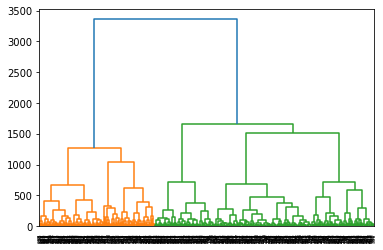

In [36]:
dendrogram(linked)

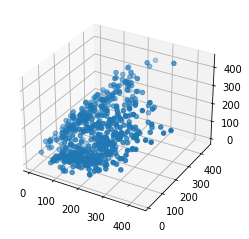

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(gleason_points[:,0], gleason_points[:,1], gleason_points[:,2],'o')
plt.show()